In [21]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split, user_based_train_test_split
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.evaluation import rmse_score, mrr_score, precision_recall_score, sequence_mrr_score, sequence_precision_recall_score
import numpy as np
import pandas
from functools import partial
from pathlib import Path
from tqdm import tqdm
from spotlight.sequence.implicit import ImplicitSequenceModel
import matplotlib.pyplot as plt

In [34]:
BEST_OF = 50
RANDOM_STATE = 42
ITERATIONS = 30
REPEAT = 5

# Utils

In [74]:
def factorization_test(model, test_data):
    h_top = 0
    for user, movies, movie in test_data:
        items = model.predict(user)
        new_items = np.delete(items, movies)
        top_items = np.argpartition(new_items, -BEST_OF)[-BEST_OF:]
        
        if movie in top_items:
            h_top += 1
    h_top = h_top / len(test_data) 
    # print(f"h_top: {h_top}")
    return h_top

def sequential_test(model, test_data):
    h_top = 0
    for user, movies, movie in test_data:
        items = model.predict(movies)
        new_items = np.delete(items, movies)
        top_items = np.argpartition(items, -BEST_OF)[-BEST_OF:]
        
        
        if movie in top_items:
            h_top += 1
    h_top = h_top / len(test_data) 
    # print(f"h_top: {h_top}")
    return h_top

def train_test(model_const, iterations, train_data ,test_data, repeat, name, is_fac = True):
    results = []
    model = model_const()
    for __ in range(repeat):
        for ii in range(iterations):
            model.fit(train_data, verbose=False)
            if is_fac:
                ft = factorization_test(model, test_data)
            else:
                ft = sequential_test(model, test_data)
            results.append((ii+1,ft))
    
    results = np.array(results)
    results_pd = pandas.DataFrame(results, columns=['iteration', 'hit_rate']).groupby('iteration').agg(["mean", "std"])
    plt.ylim(.0, .2)
    plt.plot(results_pd[('hit_rate','mean')])
    plt.xlabel('iterations')
    plt.ylabel('hit_rate')
    plt.fill_between(results_pd.index, results_pd[('hit_rate','mean')] + results_pd[('hit_rate','std')], results_pd[('hit_rate','mean')] - results_pd[('hit_rate','std')], color='b', alpha=0.2)
    plt.title(name)
    plt.grid(True)
    plt.savefig(f'img/{IMG_TYPE}_{name}.pdf')
    plt.show()
    print('Max hit_rate ', results_pd[('hit_rate','mean')].max())
    return (results_pd, model)

# Test 100k

## Prepare_100k

In [118]:
IMG_TYPE = '100k'
ITERATIONS = 20
REPEAT = 5

In [119]:
ratings_df = pandas.read_csv(Path('private/ml-100k/u.data'), sep='\t', header=0, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [120]:
ratings_test_df  = ratings_df.sort_values('Timestamp').groupby('UserID').tail(1)

In [121]:
ratings_train_df = pandas.concat([ratings_df, ratings_test_df]).drop_duplicates(keep=False)

In [122]:
print(len(ratings_train_df), len(ratings_test_df))
len(ratings_train_df) + len(ratings_test_df) == len(ratings_df)

99056 943


True

In [123]:
interactions = Interactions(
    user_ids=ratings_train_df['UserID'].to_numpy(dtype=np.int32),
    item_ids=ratings_train_df['MovieID'].to_numpy(dtype=np.int32),
    ratings=ratings_train_df['Rating'].to_numpy(dtype=np.float32),
    timestamps=ratings_train_df['Timestamp'].to_numpy(dtype=np.int32)
)

In [124]:
train = interactions

In [125]:
test_list = list(ratings_test_df[['UserID', 'MovieID']].merge(ratings_train_df[['UserID', 'MovieID']].groupby('UserID')['MovieID'].apply(list).reset_index(name='MovieIDs'))[['UserID','MovieIDs', 'MovieID']].to_records(index=False))

## ExplicitFactorizationModel

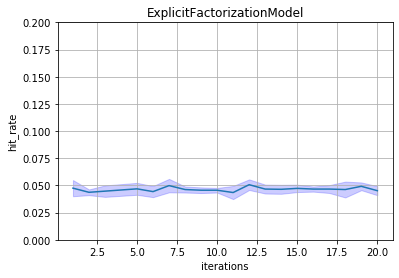

Max hit_rate  0.05068928950159067


In [126]:
ef_model = partial(ExplicitFactorizationModel,n_iter=1, use_cuda=True)
x = train_test(ef_model, ITERATIONS, train, test_list, REPEAT , 'ExplicitFactorizationModel')

## ImplicitFactorizationModel

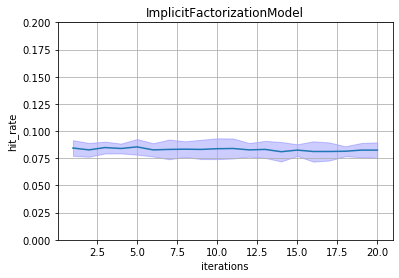

Max hit_rate  0.08547189819724284


In [127]:
if_model = partial(ImplicitFactorizationModel,n_iter=1, use_cuda=True)
x = train_test(if_model, ITERATIONS, train, test_list, REPEAT, 'ImplicitFactorizationModel')

## Sequence models

### Pooling

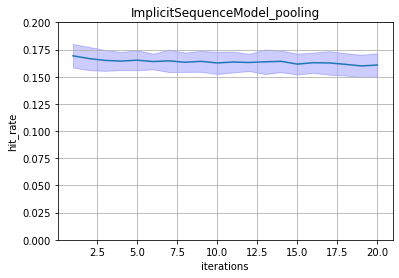

Max hit_rate  0.16924708377518558


In [128]:
seq_pool_model = partial(ImplicitSequenceModel,n_iter=1, representation='pooling', use_cuda=True)
x = train_test(seq_pool_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_pooling', False)

### LSTM

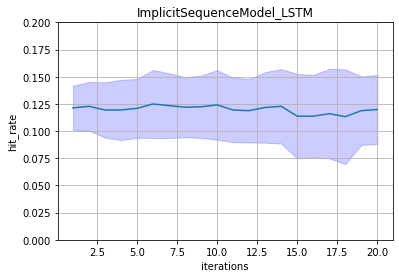

Max hit_rate  0.12492046659597031


In [129]:
seq_lstm_model = partial(ImplicitSequenceModel,n_iter=1, representation='lstm', use_cuda=True)
x = train_test(seq_lstm_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_LSTM', False)

## CNN

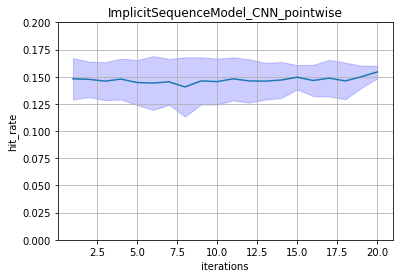

Max hit_rate  0.15440084835630963


In [130]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True)
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_pointwise',  False)

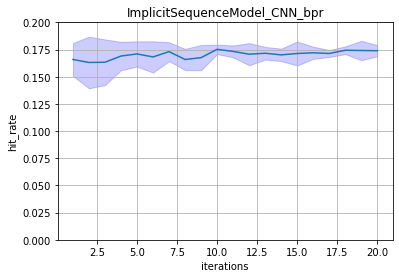

Max hit_rate  0.17518557794273595


In [131]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='bpr')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_bpr', False)

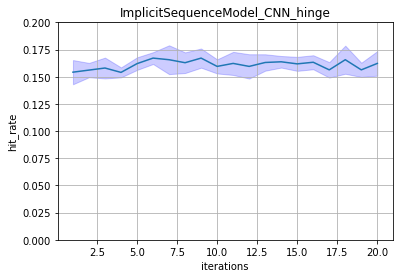

Max hit_rate  0.16712619300106046


In [132]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_hinge', False)

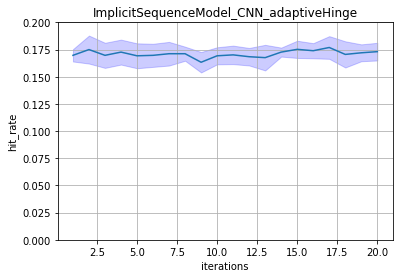

Max hit_rate  0.17688229056203605


In [133]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='adaptive_hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_adaptiveHinge', False)

# Test 1M

## Prepare_1M

In [85]:
IMG_TYPE = '1M'
ITERATIONS = 10
REPEAT = 3

In [86]:
ratings_df = pandas.read_csv(Path('private/ml-1m/ratings.dat'), sep='::', engine='python', header=0, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [87]:
ratings_test_df  = ratings_df.sort_values('Timestamp').groupby('UserID').tail(1)

In [88]:
ratings_train_df = pandas.concat([ratings_df, ratings_test_df]).drop_duplicates(keep=False)

In [89]:
print(len(ratings_train_df), len(ratings_test_df))
len(ratings_train_df) + len(ratings_test_df) == len(ratings_df)

994168 6040


True

In [90]:
interactions = Interactions(
    user_ids=ratings_train_df['UserID'].to_numpy(dtype=np.int32),
    item_ids=ratings_train_df['MovieID'].to_numpy(dtype=np.int32),
    ratings=ratings_train_df['Rating'].to_numpy(dtype=np.float32),
    timestamps=ratings_train_df['Timestamp'].to_numpy(dtype=np.int32)
)

In [91]:
train = interactions

In [92]:
test_list = list(ratings_test_df[['UserID', 'MovieID']].merge(ratings_train_df[['UserID', 'MovieID']].groupby('UserID')['MovieID'].apply(list).reset_index(name='MovieIDs'))[['UserID','MovieIDs', 'MovieID']].to_records(index=False))

## ExplicitFactorizationModel

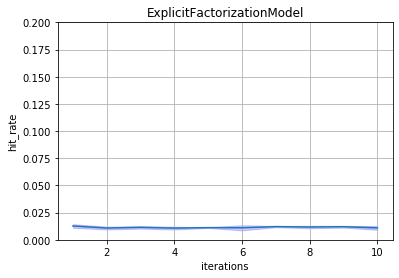

Max hit_rate  0.012693156732891833


In [93]:
ef_model = partial(ExplicitFactorizationModel,n_iter=1, use_cuda=True)
x = train_test(ef_model, ITERATIONS, train, test_list, REPEAT , 'ExplicitFactorizationModel')

## ImplicitFactorizationModel

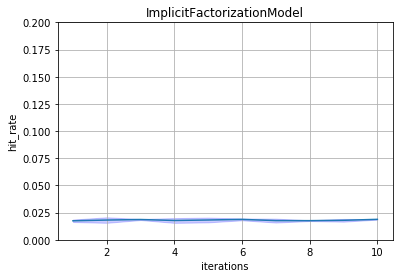

Max hit_rate  0.01881898454746137


In [94]:
if_model = partial(ImplicitFactorizationModel,n_iter=1, use_cuda=True)
x = train_test(if_model, ITERATIONS, train, test_list, REPEAT, 'ImplicitFactorizationModel')

## Sequence models

### Pooling

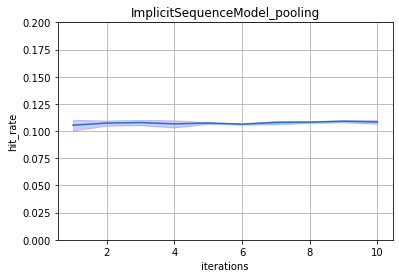

Max hit_rate  0.10905077262693157


In [95]:
seq_pool_model = partial(ImplicitSequenceModel,n_iter=1, representation='pooling', use_cuda=True)
x = train_test(seq_pool_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_pooling', False)

### LSTM

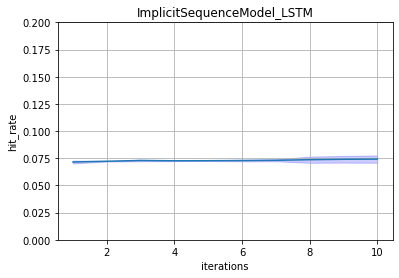

Max hit_rate  0.07422737306843268


In [96]:
seq_lstm_model = partial(ImplicitSequenceModel,n_iter=1, representation='lstm', use_cuda=True)
x = train_test(seq_lstm_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_LSTM', False)

## CNN

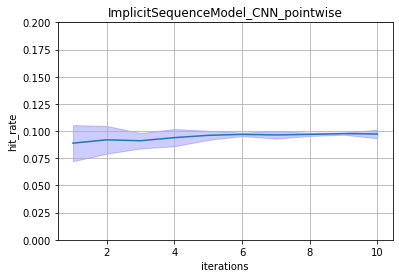

Max hit_rate  0.09768211920529801


In [97]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True)
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_pointwise',  False)

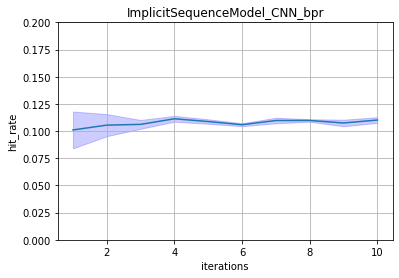

Max hit_rate  0.11131346578366445


In [98]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='bpr')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_bpr', False)

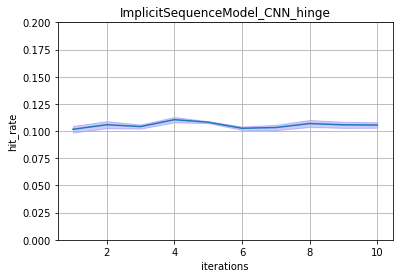

Max hit_rate  0.11048565121412803


In [99]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_hinge', False)

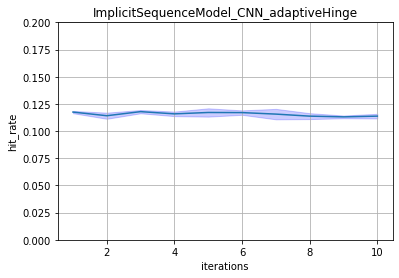

Max hit_rate  0.11788079470198676


In [100]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='adaptive_hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_adaptiveHinge', False)

# Test 100k-64 dimension embedding

## Prepare_100k

In [102]:
IMG_TYPE = '100k-64'
ITERATIONS = 20
REPEAT = 5

In [103]:
ratings_df = pandas.read_csv(Path('private/ml-100k/u.data'), sep='\t', header=0, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [104]:
ratings_test_df  = ratings_df.sort_values('Timestamp').groupby('UserID').tail(1)

In [105]:
ratings_train_df = pandas.concat([ratings_df, ratings_test_df]).drop_duplicates(keep=False)

In [106]:
print(len(ratings_train_df), len(ratings_test_df))
len(ratings_train_df) + len(ratings_test_df) == len(ratings_df)

99056 943


True

In [107]:
interactions = Interactions(
    user_ids=ratings_train_df['UserID'].to_numpy(dtype=np.int32),
    item_ids=ratings_train_df['MovieID'].to_numpy(dtype=np.int32),
    ratings=ratings_train_df['Rating'].to_numpy(dtype=np.float32),
    timestamps=ratings_train_df['Timestamp'].to_numpy(dtype=np.int32)
)

In [108]:
train = interactions

In [109]:
test_list = list(ratings_test_df[['UserID', 'MovieID']].merge(ratings_train_df[['UserID', 'MovieID']].groupby('UserID')['MovieID'].apply(list).reset_index(name='MovieIDs'))[['UserID','MovieIDs', 'MovieID']].to_records(index=False))

## ExplicitFactorizationModel

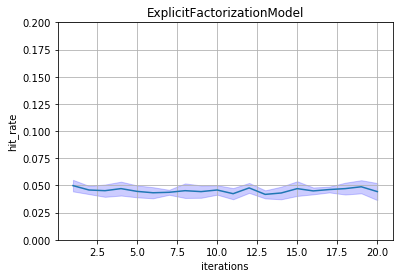

Max hit_rate  0.04984093319194062


In [110]:
ef_model = partial(ExplicitFactorizationModel,n_iter=1, embedding_dim=64, use_cuda=True)
x = train_test(ef_model, ITERATIONS, train, test_list, REPEAT , 'ExplicitFactorizationModel')

## ImplicitFactorizationModel

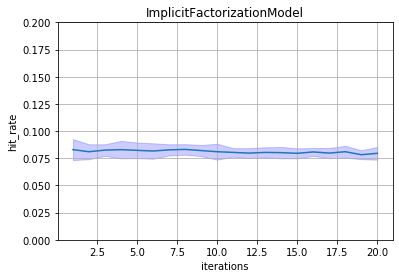

Max hit_rate  0.08313891834570519


In [111]:
if_model = partial(ImplicitFactorizationModel,n_iter=1, embedding_dim=64, use_cuda=True)
x = train_test(if_model, ITERATIONS, train, test_list, REPEAT, 'ImplicitFactorizationModel')

## Sequence models

### Pooling

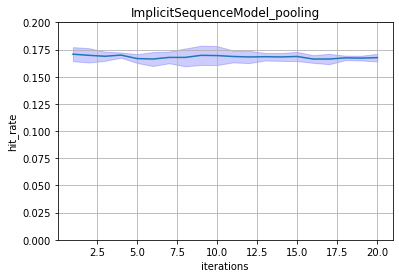

Max hit_rate  0.17073170731707318


In [112]:
seq_pool_model = partial(ImplicitSequenceModel,n_iter=1, representation='pooling', embedding_dim=64, use_cuda=True)
x = train_test(seq_pool_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_pooling', False)

### LSTM

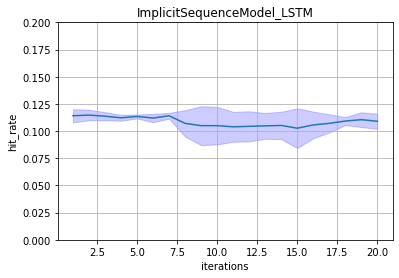

Max hit_rate  0.11474019088016967


In [113]:
seq_lstm_model = partial(ImplicitSequenceModel,n_iter=1, representation='lstm', embedding_dim=64, use_cuda=True)
x = train_test(seq_lstm_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_LSTM', False)

## CNN

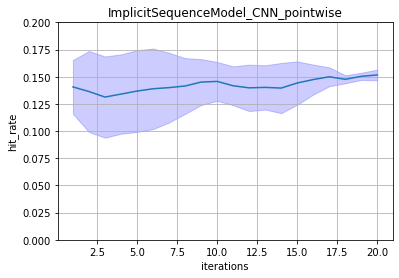

Max hit_rate  0.15164369034994699


In [114]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', embedding_dim=64, use_cuda=True)
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_pointwise',  False)

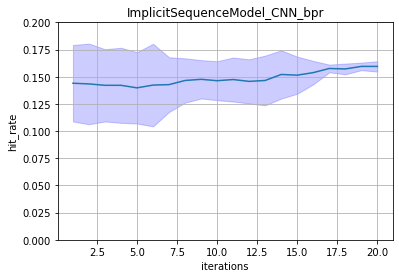

Max hit_rate  0.15949098621420998


In [115]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', embedding_dim=64, use_cuda=True)
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_bpr', False)

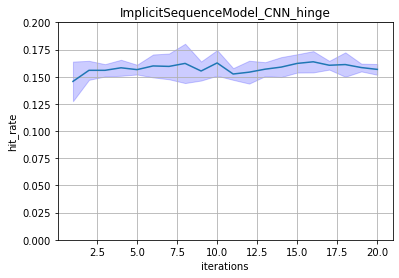

Max hit_rate  0.16373276776246024


In [116]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', embedding_dim=64, use_cuda=True, loss='hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_hinge', False)

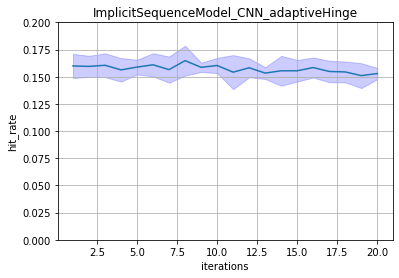

Max hit_rate  0.1647932131495228


In [117]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', embedding_dim=64, use_cuda=True, loss='adaptive_hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, 'ImplicitSequenceModel_CNN_adaptiveHinge', False)